In [1]:
import sys
sys.path.insert(0, "D:\ISEN\M1\Projet M1\KimiaNet\Scripts")
import KimiaNet_AutoEncoder as Kn
import numpy as np

In [2]:
autoencoder = Kn.KimiaNetAutoencoder()

In [3]:
import tensorflow as tf, time

x = tf.ones((128,224,224,3), tf.uint8)

start = time.time()
y = autoencoder.model(x)
end = time.time()
end - start

4.8623175621032715

In [4]:
y.shape

TensorShape([128, 224, 224, 3])

In [3]:
x = Kn.create_train_dataset("D:\\ISEN\\M1\\Projet M1\\DLBCL-Morph\\Patches\\HE")

In [4]:
patches = np.array_split(x, len(x) / 8)

In [22]:
from sklearn.model_selection import train_test_split
# Split the dataset into train and test
x_train, x_test = train_test_split(patches, test_size=0.2, random_state=42)

In [5]:
# Create a batch of 32 images
x_batch = x_train[-1]
x_batch.shape

(8, 224, 224, 3)

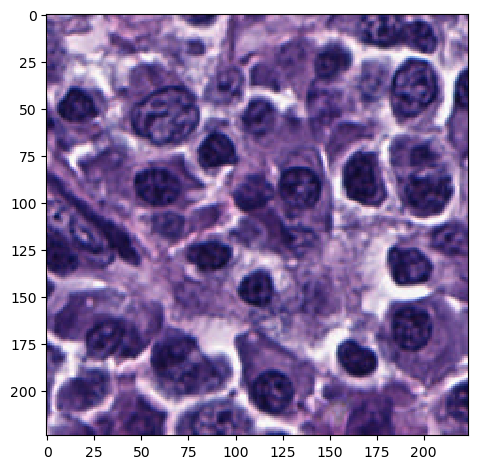

In [6]:
# affiche la première image
import skimage.io as io
io.imshow(x[1])

In [7]:
import imgaug as ia
import imgaug.augmenters as iaa

ia.seed(1)
seq = iaa.Sequential([
    iaa.Crop(percent=(0, 0.2)), # crop images from each side by 0 to 20% (randomly chosen)
    iaa.Sometimes(
        0.6,
        iaa.GaussianBlur(sigma=(0, 3))
    ),
    iaa.Sometimes(
        0.3,
        iaa.ElasticTransformation(alpha=(0,70), sigma=5)
    ),
    iaa.LinearContrast((0.75, 1.5)),
    iaa.Affine(
        rotate=(-90, 90),
    )
], random_order=True) # apply augmenters in random order


In [ ]:
x_batch_aug = seq(images=x_batch)

In [8]:
x_batch_aug.shape

(8, 224, 224, 3)

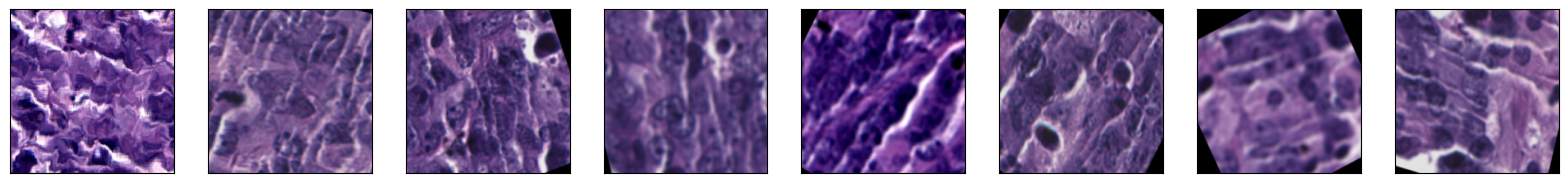

In [9]:
# Display the 32 images
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(8):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(x_batch_aug[i])


In [8]:
def batch_preprocessing(batch):
    batch_aug = seq(images=batch)
    batch_aug = preprocess_input(batch_aug)
    batch_aug = tf.cast(batch_aug, tf.float32)
    return batch_aug

In [24]:
def preprocessing(x):
    x_aug = []
    for batch_ in x:
        batch_aug = batch_preprocessing(batch_)
        x_aug.append(batch_aug)
    return x_aug

In [10]:
from tensorflow.keras.applications.densenet import preprocess_input
import tensorflow as tf
# Preprocess the images
x_batch_aug = preprocess_input(x_batch_aug)

In [11]:
x_batch_aug = tf.convert_to_tensor(x_batch_aug)

In [12]:
x_batch_aug = tf.cast(x_batch_aug, tf.float32)

In [13]:
autoencoder.freeze_encoder()

In [14]:
autoencoder.compile()

In [15]:
y_batch = tf.cast(x_batch, tf.float32)

In [ ]:
x_train_aug = preprocessing(x_train)
x_test_aug = preprocessing(x_test)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(x, test_size=0.2, random_state=42)

In [ ]:
import tensorflow as tf
y_train = x_train.copy()
y_train = tf.cast(y_train, tf.float32)
y_test = x_test.copy()
y_test = tf.cast(y_test, tf.float32)

In [ ]:
x_train_aug = seq(images=x_train)
x_train_aug = preprocess_input(x_train_aug)
x_train_aug = tf.cast(x_train_aug, tf.float32)
x_val_aug = seq(images=x_val)
x_val_aug = preprocess_input(x_val_aug)
x_val_aug = tf.cast(x_val_aug, tf.float32)


In [ ]:
autoencoder.model.fit(
    x_train_aug,
    y_train,
    batch_size=8,
    epochs=10,
    verbose=1,
    validation_data=(x_test_aug, y_test),
    shuffle=True,
    initial_epoch=0,
)

In [16]:
for i in range(10):
    print("Epoch: ", i)
    for j in range(len(x_train)):
        batch = batch_preprocessing(x_train[j])
        autoencoder.model.train_on_batch(
            batch,
            y_batch,
            sample_weight=None,
            class_weight=None,
            reset_metrics=True,
            return_dict=False,
        )

    for j in range(len(x_test)):
        autoencoder.model.test_on_batch(
            x_batch_aug,
            y_batch,
            sample_weight=None,
            reset_metrics=True,
            return_dict=False,
        )

Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9


In [17]:
output = autoencoder.model.predict(x_batch_aug)

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


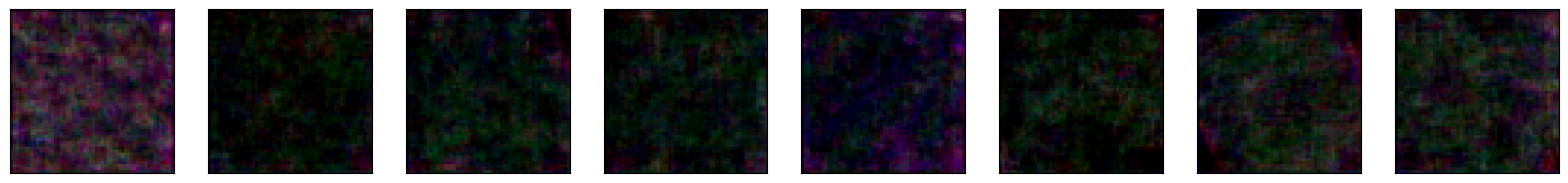

In [18]:
# Display the 8 images
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i in range(8):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(output[i])

In [1]:
import pickle
extracted_features_save_adr = "../extracted_features.pickle"

# read extracted features from pickle file
def read_extracted_features(extracted_features_save_adr):
    with open(extracted_features_save_adr, 'rb') as input_file:
        return pickle.load(input_file)


features = read_extracted_features(extracted_features_save_adr)
features = dict(features)